In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [6]:
import numpy as np
import os
import cv2
import dlib
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
import logging
import pickle

# Configure logging
logging.basicConfig(level=logging.INFO)

def load_face_recognition_models():
    """
    Load the face detection, landmark predictor, and face recognition models.
    """
    face_detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor("/Users/simranbirkaur/Desktop/capstone_final/Face-Recognition-Based-Attendance-System/shape_predictor_68_face_landmarks.dat")
    face_encoder = dlib.face_recognition_model_v1("/Users/simranbirkaur/Desktop/capstone_final/Face-Recognition-Based-Attendance-System/dlib_face_recognition_resnet_model_v1.dat")
    return face_detector, shape_predictor, face_encoder


def extract_face_encodings(image, face_detector, shape_predictor, face_encoder):
    """
    Extract facial encodings from an image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = face_detector(gray, 1)
    encodings = [np.array(face_encoder.compute_face_descriptor(image, shape_predictor(gray, rect))) for rect in rects]
    return encodings


def preprocess_images_and_labels(images_folder, face_detector, shape_predictor, face_encoder):
    """
    Preprocess images and extract encodings and labels.
    """
    encodings = []
    labels = []
    for root, dirs, files in os.walk(images_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is None:
                    logging.error(f"Failed to load image: {image_path}")
                    continue
                face_encs = extract_face_encodings(image, face_detector, shape_predictor, face_encoder)
                encodings.extend(face_encs)
                labels.extend([os.path.basename(root)])
                
                #Saving encosings in a pickle file
               # save_encodings(os.path.basename(root), face_encs )

    le = LabelEncoder()
    labels_encoded1 = le.fit_transform(labels)
    print("encoded labels", labels_encoded1)
    joblib.dump(le, 'label_encoder.pkl')
    num_classes = len(le.classes_)
    labels_encoded = to_categorical(labels_encoded1, num_classes)  # Convert labels to one-hot encoding
    
    return np.array(encodings), np.array(labels_encoded), num_classes, labels_encoded1

def build_model(input_shape, num_classes):
    """
    Build the CNN model.
    """
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


def train_model(model, X_train, y_train, X_test, y_test):
    """
    Train the CNN model.
    """
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)
   
    plot_training_history(history)
    return model, history


def evaluate_model(model, X_test, y_test, labels):
    """
    Evaluate the trained CNN model.
    """
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print("labels", labels)
    plot_confusion_matrix(y_true, y_pred,labels )

    confidence_scores = np.max(y_pred_prob, axis=1)
    logging.info("Confidence Scores: %s", confidence_scores)
    accuracy = accuracy_score(y_true, y_pred)
    logging.info("Test Accuracy: %s", accuracy)


def loadModel():
    # Load face recognition models
    face_detector, shape_predictor, face_encoder = load_face_recognition_models()

    # Preprocess images and labels
    encodings, labels, num_classes, labelencoded1 = preprocess_images_and_labels('/Users/simranbirkaur/Desktop/capstone_final/Face-Recognition-Based-Attendance-System/images', face_detector, shape_predictor, face_encoder)

    # Preprocess data
    X_train, X_test, y_train, y_test = train_test_split(encodings, labels, test_size=0.2, random_state=42,
                                                        stratify=labels)

    # Build CNN model
    model = build_model(input_shape=X_train.shape[1:], num_classes=num_classes)

    # Train CNN model
    trained_model, history = train_model(model, X_train, y_train, X_test, y_test)

    # Evaluate CNN model
    evaluate_model(trained_model, X_test, y_test, labelencoded1)

    plot_learning_curves(X_train, y_train)

#Loss 
def plot_training_history(history):
        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

#Accuracy
def plot_learning_curves(X, y):
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

    print(X)
    print(y)

    # Define the parameters for learning_curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=random_forest,  # Use RandomForestClassifier as the estimator
        X=X,  # Your training data
        y=y,  # Your training labels
        train_sizes=np.linspace(0.1, 1.0, 10),  # Specify the training sizes
        cv=5  # Number of cross-validation folds
    )

    # Calculate the mean and standard deviation of training and test scores
    train_mean = np.mean(train_scores, axis=1)
    print("idar",train_mean)
    train_std = np.std(train_scores, axis=1)
    print(train_std)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.5, 1.0])
    plt.grid()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot the confusion matrix using seaborn.
    """
    # Convert the labels array to a list if it's a NumPy array
    unique_labels = np.unique(labels)
    cm = sk_confusion_matrix(y_true, y_pred, labels=unique_labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    cm_display.plot()
    plt.show()


encoded labels [ 8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  2  2  2  2
  2  2  2  2  2  2  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6
  6  6  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  3  3
  3  3  3  3  3  3  3  3 10 10 10 10 10 10 10 10 10 10  1  1  1  1  1  1
  1  1  1  1  0  0  0  0  0  0  0  0  0  0]


/Users/simranbirkaur/Python_Miniconda/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.0575 - loss: 2.4170 - val_accuracy: 0.1364 - val_loss: 2.3574
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1246 - loss: 2.3498 - val_accuracy: 0.2727 - val_loss: 2.3236
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1861 - loss: 2.3250 - val_accuracy: 0.5000 - val_loss: 2.2919
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2670 - loss: 2.3021 - val_accuracy: 0.6818 - val_loss: 2.2606
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3825 - loss: 2.2458 - val_accuracy: 1.0000 - val_loss: 2.2296
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5710 - loss: 2.2159 - val_accuracy: 1.0000 - val_loss: 2.1976
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6477 - loss: 2.1901 - val_accuracy: 1.0000 - val_loss: 2.1658
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6928 - loss: 2.1599 - val_accuracy: 1.0000 - val_loss: 2.1341

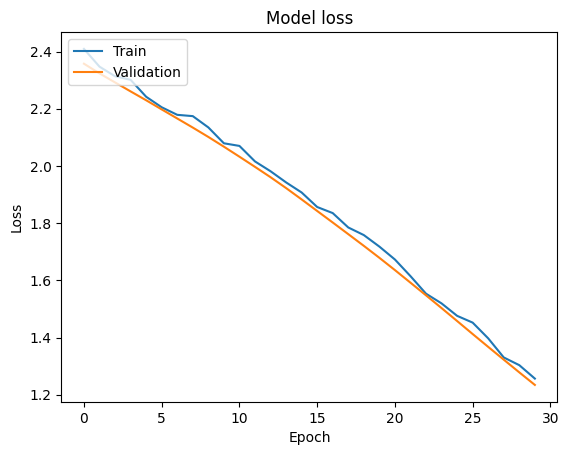

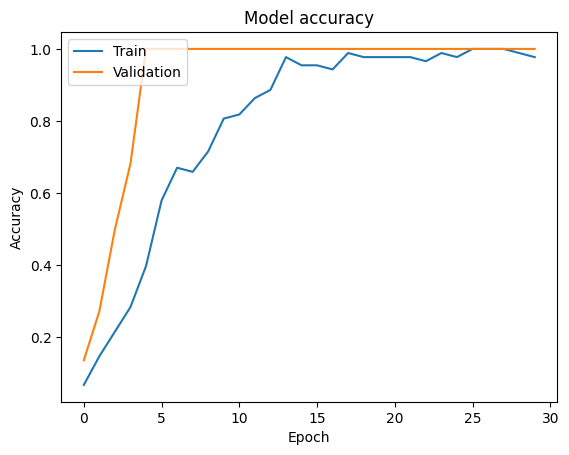

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
labels [ 8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  2  2  2  2
  2  2  2  2  2  2  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6
  6  6  5  5  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7  7  3  3
  3  3  3  3  3  3  3  3 10 10 10 10 10 10 10 10 10 10  1  1  1  1  1  1
  1  1  1  1  0  0  0  0  0  0  0  0  0  0]


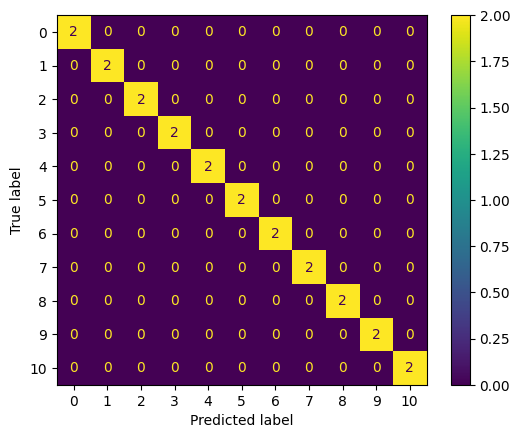

INFO:root:Confidence Scores: [0.25228485 0.25649774 0.3729569  0.25637415 0.30335072 0.3220482
 0.33489975 0.2428655  0.26969716 0.22382246 0.26937744 0.37150624
 0.38829786 0.37216613 0.30050528 0.34483856 0.2636827  0.3342138
 0.2298553  0.2539045  0.28761095 0.24471551]
INFO:root:Test Accuracy: 1.0


[[-1.03558272e-01  7.89504945e-02  9.72128361e-02 ... -5.57526946e-05
   8.66877288e-02  5.52689359e-02]
 [-1.77969918e-01  1.11092024e-01  2.95999367e-02 ...  9.52901691e-03
   1.35862827e-01  8.37996900e-02]
 [-9.13605615e-02 -8.46022367e-03  9.33640450e-02 ... -2.63293907e-02
   3.78655940e-02  4.10046577e-02]
 ...
 [-1.36959240e-01  4.27092612e-03  1.67007059e-01 ...  7.36133456e-02
   1.09764978e-01  8.97510126e-02]
 [-1.47554994e-01  7.39938170e-02  3.24781500e-02 ... -2.61841416e-02
   4.63535488e-02  3.49454358e-02]
 [-1.72145575e-01  5.58981672e-02 -9.04943608e-03 ... -2.36705691e-02
   8.76943469e-02  6.44094199e-02]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0.

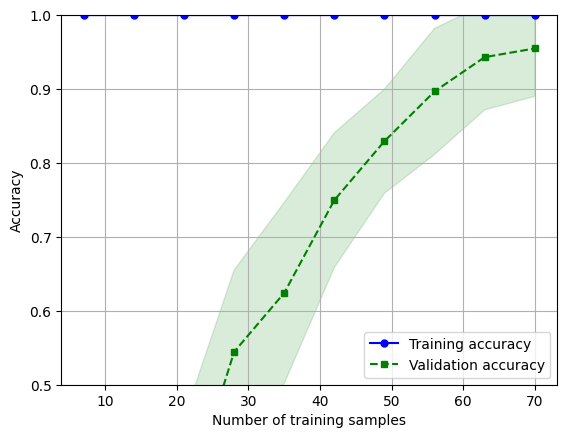

In [7]:
loadModel()